In [87]:
import os
import random
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize

In [2]:
def show_slices(slices):
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
           axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [3]:
# read T1 file data
case1 = nib.load("case_1/T1.nii.gz")
case1Data = case1.get_fdata()

In [4]:
case1Data.shape

(128, 144, 128)

Text(0.5, 0.98, 'Center slices for EPI image')

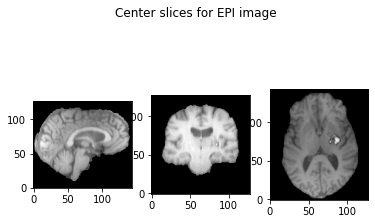

In [5]:
slice_0 = case1Data[64, :, :] # saggital slice
slice_1 = case1Data[:, 72, :] # coronal slice
slice_2 = case1Data[:, :, 64] # axial slice
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image") 

In [25]:
res = resize(case1Data,(128,128,128),order=1,preserve_range=True)

In [26]:
res.shape

(128, 128, 128)

## Import training and testing data

In [93]:
imgWidth,imgHeight = 128,128
X_train = np.zeros((20*128*3,128,128,1),dtype=np.uint8)
Y_train = np.zeros((20*128*3,128,128,1),dtype=np.bool)

In [94]:
niiData = []
maskLData = []
maskRData = []
for i in range(1,21):
    imgData = nib.load("train_data/case_"+str(i)+"/T1.nii.gz").get_fdata()
    niiData.append(resize(imgData,(128,128,128),order=1,preserve_range=True))
    imgData = nib.load("train_data/case_"+str(i)+"/OR_left.nii.gz").get_fdata()
    maskLData.append(resize(imgData,(128,128,128),order=1,preserve_range=True))
    imgData = nib.load("train_data/case_"+str(i)+"/OR_right.nii.gz").get_fdata()
    maskRData.append(resize(imgData,(128,128,128),order=1,preserve_range=True))

In [96]:
testData = []
for i in range(21,23):
    imgData = nib.load("case_"+str(i)+"/T1.nii.gz").get_fdata()
    testData.append(resize(imgData,(128,128,128),order=1,preserve_range=True))

In [99]:
n=0
for i in range(20):
    for j in range(128):
        X_train[n] = resize(niiData[i][j,:,:],(imgHeight,imgWidth,1),mode='constant',preserve_range=True) #saggital slices
        maskL_ = np.expand_dims(maskLData[i][j,:,:],axis=-1)
        maskR_ = np.expand_dims(maskRData[i][j,:,:],axis=-1)
        Y_train[n] = np.maximum(maskL_,maskR_)
        n += 1
        X_train[n] = resize(niiData[i][:,j,:],(imgHeight,imgWidth,1),mode='constant',preserve_range=True) #coronal slices
        maskL_ = np.expand_dims(maskLData[i][:,j,:],axis=-1)
        maskR_ = np.expand_dims(maskRData[i][:,j,:],axis=-1)
        Y_train[n] = np.maximum(maskL_,maskR_)
        n += 1
        X_train[n] = resize(niiData[i][:,:,j],(imgHeight,imgWidth,1),mode='constant',preserve_range=True) #axial slices
        maskL_ = np.expand_dims(maskLData[i][:,:,j],axis=-1)
        maskR_ = np.expand_dims(maskRData[i][:,:,j],axis=-1)
        Y_train[n] = np.maximum(maskL_,maskR_)
        n += 1

In [130]:
X_test = np.zeros((2*128*3,128,128,1),dtype=np.uint8)

In [131]:
n=0
for i in range(2):
    for j in range(128):
        X_test[n] = np.expand_dims(testData[i][j,:,:],axis=-1) #saggital slices
        n += 1
        X_test[n] = np.expand_dims(testData[i][:,j,:],axis=-1) #coronal slices
        n += 1
        X_test[n] = np.expand_dims(testData[i][:,:,j],axis=-1) #axial slices
        n += 1

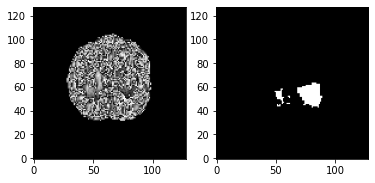

In [125]:
show_slices([X_train[55][:,:,0],Y_train[55][:,:,0]])

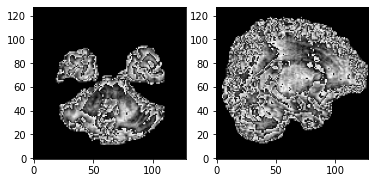

In [132]:
show_slices([X_test[110][:,:,0],X_test[510][:,:,0]])

## U-Net Model

In [56]:
# create model for each mri viewe
# create input layer
inputs = tf.keras.layers.Input((imgWidth,imgHeight,1))
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)
# encoder layers
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c4)

c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)

# decoder layers
u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1],axis=3)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

# output layer
outputs = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

#saggital u-net model
model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 128, 128, 1)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 128, 128, 16) 160         lambda_7[0][0]                   
__________________________________________________________________________________________________
dropout_54 (Dropout)            (None, 128, 128, 16) 0           conv2d_114[0][0]                 
____________________________________________________________________________________________

## Train model

In [14]:
# model checkpoints
checkpointer = tf.keras.callbacks.ModelCheckpoint('u-net_model.h5',verbose=1,save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='model_logs')
]

In [126]:
# fit model
results = model.fit(X_train,Y_train,validation_split=0.1,batch_size=16,epochs=2,callbacks=callbacks)

Epoch 1/2
432/432 [==============================] - 757s 2s/step - loss: 0.4403 - accuracy: 0.9890 - val_loss: 1.1976 - val_accuracy: 0.7164
Epoch 2/2
432/432 [==============================] - 758s 2s/step - loss: 0.0363 - accuracy: 0.9914 - val_loss: 1.9739 - val_accuracy: 0.7164


In [127]:
results

In [128]:
# save model
model.save('or_unet_model.h5')

## Test model

In [88]:
idx = random.randint(0,len(X_train))

In [ ]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)],verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
preds_test = model.predict(X_test,verbose=1)

In [137]:
prediction = model.predict(X_test,verbose=1)

24/24 [==============================] - 16s 660ms/step


In [139]:
prediction.shape

(768, 128, 128, 1)

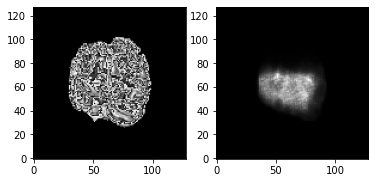

In [143]:
show_slices([X_test[55][:,:,0],prediction[55][:,:,0]])

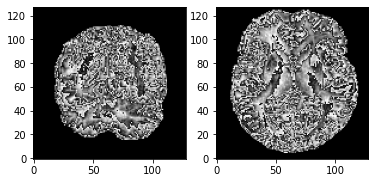

In [135]:
show_slices([X_test[100][:,:,0],X_test[200][:,:,0]])